## warning : 환경 바꿔야 함.

conda activate pointnext

In [1]:
cd /data/wlsgur4011/part_assembly/src/pointnext

/data/wlsgur4011/part_assembly/src/pointnext


In [2]:
%matplotlib widget

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from jhutil import show_point_clouds
import torch
import numpy as np

import logging
logging.getLogger().setLevel(logging.INFO)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. ShapeNet Part Segmentation

### import and config

In [ ]:
import argparse
import yaml
import os
import sys
import logging
import wandb
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import distributed as dist, multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter
from torch_scatter import scatter
import torch.nn.functional as F
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter

torch.backends.cudnn.benchmark = False
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.insert(0, "/data/wlsgur4011/part_assembly/src/pointnext/examples")

from openpoints.models import build_model_from_cfg
from openpoints.models.layers import torch_grouping_operation, knn_point
from openpoints.loss import build_criterion_from_cfg
from openpoints.scheduler import build_scheduler_from_cfg
from openpoints.optim import build_optimizer_from_cfg
from openpoints.dataset import build_dataloader_from_cfg, get_class_weights, get_features_by_keys
from openpoints.transforms import build_transforms_from_cfg
from openpoints.utils import AverageMeter, ConfusionMatrix
from openpoints.utils import set_random_seed, save_checkpoint, load_checkpoint, resume_checkpoint, setup_logger_dist, \
    cal_model_parm_nums, Wandb, generate_exp_directory, resume_exp_directory, EasyConfig, dist_utils, find_free_port
from openpoints.models.layers import furthest_point_sample



In [ ]:
import sys
# sys.argv = ["examples/segmentation/main.py" ,"--cfg" ,"cfgs/shapenetpart/pointnext-s.yaml"]
sys.argv = ["examples/segmentation/main.py" ,"--cfg" ,"cfgs/part_assembly/pointnext-l.yaml"]

In [ ]:
def get_config():
    parser = argparse.ArgumentParser('ShapeNetPart Part segmentation training')
    parser.add_argument('--cfg', type=str, required=True, help='config file')
    args, opts = parser.parse_known_args()
    cfg = EasyConfig()
    cfg.load(args.cfg, recursive=True)
    cfg.update(opts)
    if cfg.seed is None:
        cfg.seed = np.random.randint(1, 10000)
    # init distributed env first, since logger depends on the dist info.
    cfg.rank, cfg.world_size, cfg.distributed, cfg.mp = dist_utils.get_dist_info(cfg)
    cfg.sync_bn = cfg.world_size > 1

    # logger
    # init log dir
    cfg.task_name = args.cfg.split('.')[-2].split('/')[-2]  # task/dataset name, \eg s3dis, modelnet40_cls
    cfg.cfg_basename = args.cfg.split('.')[-2].split('/')[-1]  # cfg_basename, \eg pointnext-xl
    tags = [
        cfg.task_name,  # task name (the folder of name under ./cfgs
        cfg.mode,
        cfg.cfg_basename,  # cfg file name
        f'ngpus{cfg.world_size}',
        f'seed{cfg.seed}',
    ]
    opt_list = [] # for checking experiment configs from logging file
    for i, opt in enumerate(opts):
        if 'rank' not in opt and 'dir' not in opt and 'root' not in opt and 'pretrain' not in opt and 'path' not in opt and 'wandb' not in opt and '/' not in opt:
            opt_list.append(opt)
    cfg.root_dir = os.path.join(cfg.root_dir, cfg.task_name)
    cfg.opts = '-'.join(opt_list)

    cfg.is_training = cfg.mode not in ['test', 'testing', 'val', 'eval', 'evaluation']

    if cfg.mode in ['resume', 'test', 'val']:
        resume_exp_directory(cfg, pretrained_path=cfg.pretrained_path)
        cfg.wandb.tags = [cfg.mode]
    else:
        generate_exp_directory(cfg, tags, additional_id=os.environ.get('MASTER_PORT', None))
        cfg.wandb.tags = tags
    os.environ["JOB_LOG_DIR"] = cfg.log_dir
    cfg_path = os.path.join(cfg.run_dir, "cfg.yaml")
    with open(cfg_path, 'w') as f:
        yaml.dump(cfg, f, indent=2)
        os.system('cp %s %s' % (args.cfg, cfg.run_dir))
    cfg.cfg_path = cfg_path
    return cfg

cfg = get_config()

launch mp with 1 GPUs, current rank: 0


### dataloader and model

In [ ]:
val_loader = build_dataloader_from_cfg(cfg.val_batch_size,
                                       cfg.dataset,
                                       cfg.dataloader,
                                       datatransforms_cfg=cfg.datatransforms,
                                       split='val',
                                       distributed=False
                                       )
logging.info(f"length of validation dataset: {len(val_loader.dataset)}")
num_classes = val_loader.dataset.num_classes if hasattr(
    val_loader.dataset, 'num_classes') else None
if num_classes is not None:
    assert cfg.num_classes == num_classes

cfg.cls2parts = [[0], [1]]


if cfg.model.get('decoder_args', False):
    cfg.model.decoder_args.cls2partembed = val_loader.dataset.cls2partembed
if cfg.model.get('in_channels', None) is None:
    cfg.model.in_channels = cfg.model.encoder_args.in_channels
    
model : torch.nn.Module = build_model_from_cfg(cfg.model)
# model.load_state_dict(torch.load("/data/wlsgur4011/part_assembly/src/pointnext/models/shapenet_s.pth")["model"])
model.cuda()

[2023-07-17 12:30:42] [INFO] 
Totally 1711 samples in val set
[2023-07-17 12:30:42] [INFO] length of validation dataset: 1711
[2023-07-17 12:30:42] [INFO] radius: [[0.1], [0.1, 0.2, 0.2], [0.2, 0.4, 0.4, 0.4, 0.4], [0.4, 0.8, 0.8], [0.8, 1.6, 1.6]],
 nsample: [[32], [32, 32, 32], [32, 32, 32, 32, 32], [32, 32, 32], [32, 32, 32]]
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.1
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.2
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.2
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.2
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.4
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.4
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.4
nsample: 32
[2023-07-17 12:30:42] [INFO] NAME: ballquery
normaliz

BaseSeg(
  (encoder): PointNextEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): SetAbstraction(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
            )
          )
        )
      )
      (1): Sequential(
        (0): SetAbstraction(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(35, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (grouper): QueryAndGroup()
        )
        (1): InvResMLP(
          (convs): LocalAggregation(
            (convs): Sequential(
              (0): Sequential(
                (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
from examples.segmentation.main import validate, validate_sphere

validate_fn = validate if 'sphere' not in cfg.dataset.common.NAME.lower() else validate_sphere
pretrain_path = "log/part_assembly/part_assembly-train-pointnext-l-ngpus4-seed133-20230717-164009-iRRq2TtktfTLaggpLBmHea/checkpoint/part_assembly-train-pointnext-l-ngpus4-seed133-20230717-164009-iRRq2TtktfTLaggpLBmHea_ckpt_best.pth"
load_checkpoint(model, pretrain_path, cfg.get('pretrained_module', None))
# val_miou, val_macc, val_oa, val_ious, val_accs = validate_fn(model, val_loader, cfg, num_votes=1)
# val_miou
model.eval()

[2023-07-17 12:30:52] [INFO] Successful Loading the ckpt from log/part_assembly/part_assembly-train-pointnext-l-ngpus4-seed6440-20230712-141606-RmMqkUXyaLqvNuY7sB35kY/checkpoint/part_assembly-train-pointnext-l-ngpus4-seed6440-20230712-141606-RmMqkUXyaLqvNuY7sB35kY_ckpt_best.pth
[2023-07-17 12:30:52] [INFO] ckpts @ 85 epoch( {'best_val': 94.15086364746094} )


BaseSeg(
  (encoder): PointNextEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): SetAbstraction(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
            )
          )
        )
      )
      (1): Sequential(
        (0): SetAbstraction(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(35, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (grouper): QueryAndGroup()
        )
        (1): InvResMLP(
          (convs): LocalAggregation(
            (convs): Sequential(
              (0): Sequential(
                (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

1111  {
    "pos": "tensor[1, 8794, 3] n=26382 (0.1Mb) x∈[-1.915, 5.610] μ=0.940 σ=1.798",
    "x": "tensor[1, 8794, 3] n=26382 (0.1Mb) x∈[-1.000, 1.000] μ=0.001 σ=0.577",
    "y": "tensor[1, 8794] i64 69Kb x∈[0, 1] μ=0.135 σ=0.342",
    "cls": "tensor[1, 1] i64 [[0]]"
}
4444  {
    "pos": "tensor[1, 8794, 3] n=26382 (0.1Mb) x∈[-1.915, 5.610] μ=0.940 σ=1.798",
    "x": "tensor[1, 3, 8794] n=26382 (0.1Mb) x∈[-1.000, 1.000] μ=0.001 σ=0.577",
    "y": "tensor[1, 8794] i64 69Kb x∈[0, 1] μ=0.135 σ=0.342",
    "cls": "tensor[1, 1] i64 [[0]]"
}


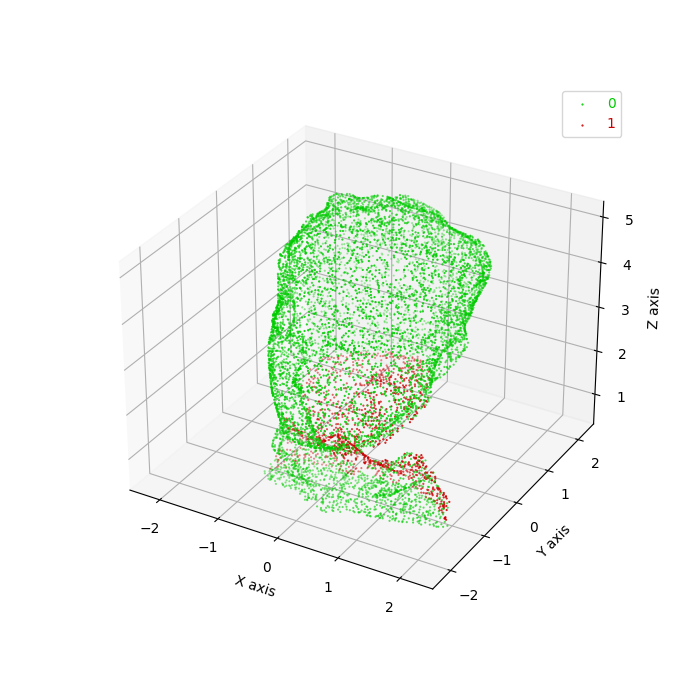

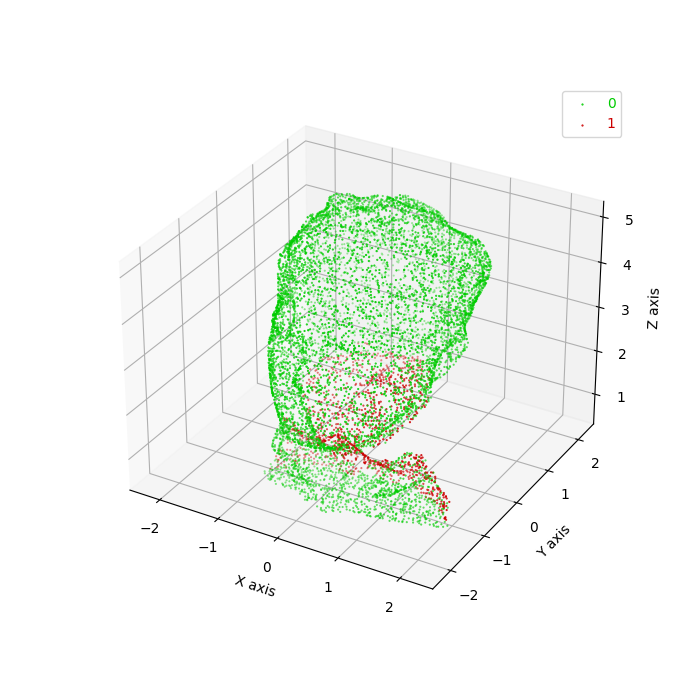

1111  {
    "pos": "tensor[1, 9052, 3] n=27156 (0.1Mb) x∈[-2.261, 5.600] μ=0.696 σ=1.699",
    "x": "tensor[1, 9052, 3] n=27156 (0.1Mb) x∈[-1.000, 1.000] μ=-0.000 σ=0.577",
    "y": "tensor[1, 9052] i64 71Kb x∈[0, 1] μ=0.021 σ=0.144",
    "cls": "tensor[1, 1] i64 [[0]]"
}
4444  {
    "pos": "tensor[1, 9052, 3] n=27156 (0.1Mb) x∈[-2.261, 5.600] μ=0.696 σ=1.699",
    "x": "tensor[1, 3, 9052] n=27156 (0.1Mb) x∈[-1.000, 1.000] μ=-0.000 σ=0.577",
    "y": "tensor[1, 9052] i64 71Kb x∈[0, 1] μ=0.021 σ=0.144",
    "cls": "tensor[1, 1] i64 [[0]]"
}


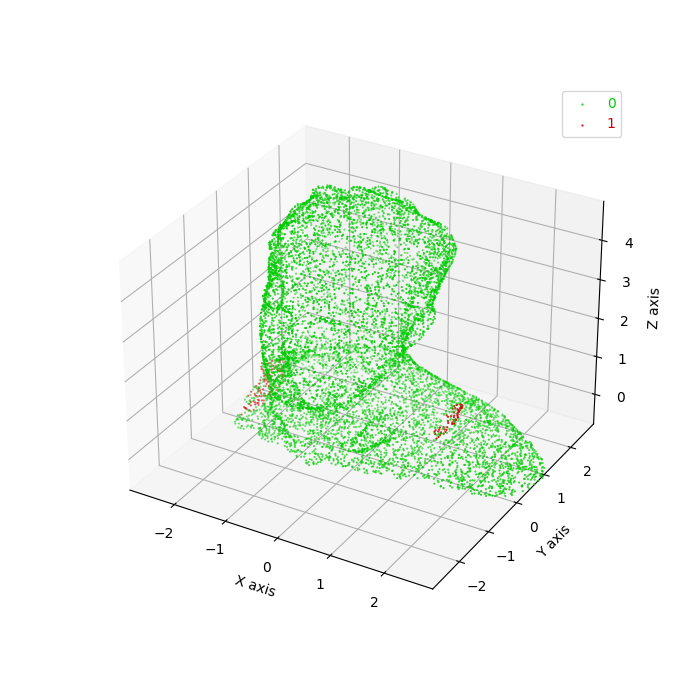

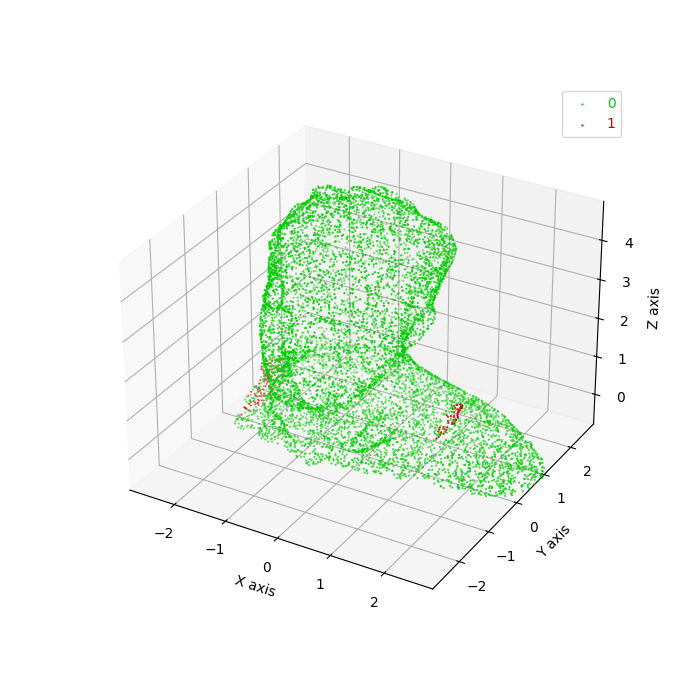

1111  {
    "pos": "tensor[1, 9029, 3] n=27087 (0.1Mb) x∈[-2.217, 5.590] μ=0.705 σ=1.701",
    "x": "tensor[1, 9029, 3] n=27087 (0.1Mb) x∈[-1.000, 1.000] μ=-0.002 σ=0.577",
    "y": "tensor[1, 9029] i64 71Kb x∈[0, 1] μ=0.014 σ=0.119",
    "cls": "tensor[1, 1] i64 [[0]]"
}
4444  {
    "pos": "tensor[1, 9029, 3] n=27087 (0.1Mb) x∈[-2.217, 5.590] μ=0.705 σ=1.701",
    "x": "tensor[1, 3, 9029] n=27087 (0.1Mb) x∈[-1.000, 1.000] μ=-0.002 σ=0.577",
    "y": "tensor[1, 9029] i64 71Kb x∈[0, 1] μ=0.014 σ=0.119",
    "cls": "tensor[1, 1] i64 [[0]]"
}


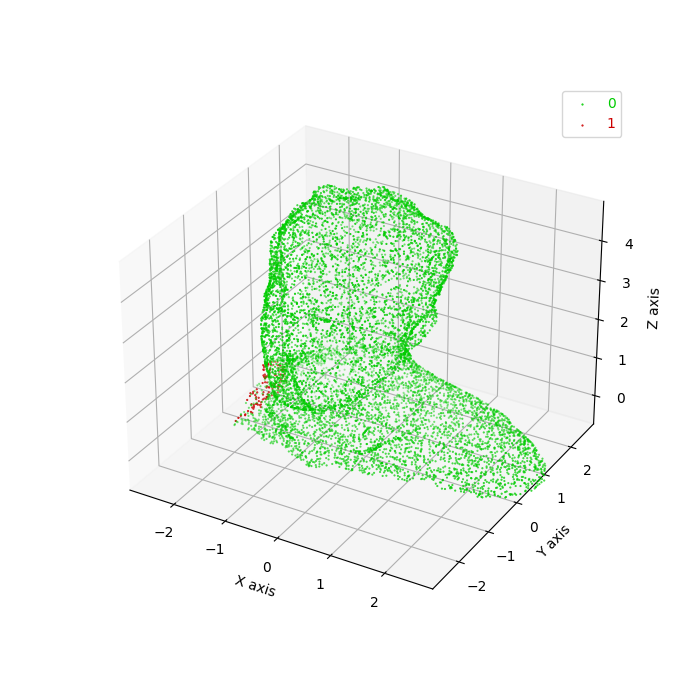

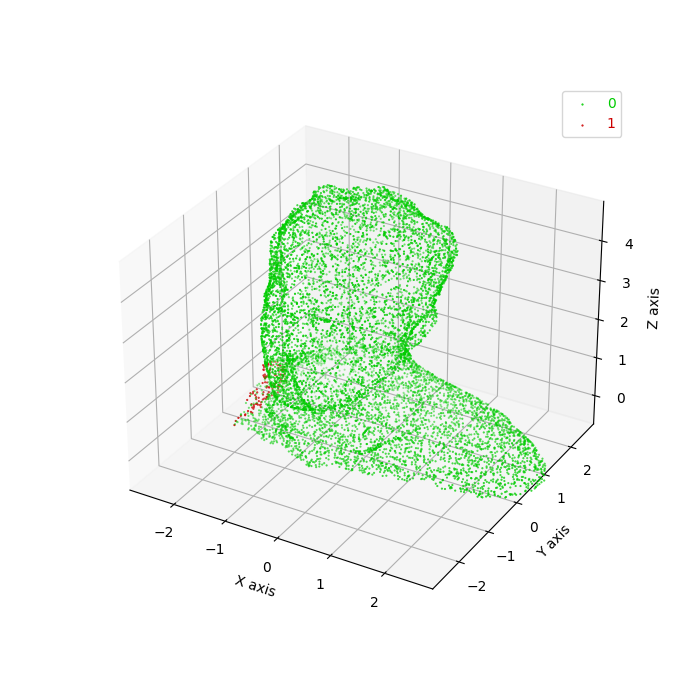

1111  {
    "pos": "tensor[1, 9058, 3] n=27174 (0.1Mb) x∈[-2.187, 5.603] μ=0.716 σ=1.712",
    "x": "tensor[1, 9058, 3] n=27174 (0.1Mb) x∈[-1.000, 1.000] μ=0.002 σ=0.577",
    "y": "tensor[1, 9058] i64 71Kb x∈[0, 1] μ=0.015 σ=0.123",
    "cls": "tensor[1, 1] i64 [[0]]"
}
4444  {
    "pos": "tensor[1, 9058, 3] n=27174 (0.1Mb) x∈[-2.187, 5.603] μ=0.716 σ=1.712",
    "x": "tensor[1, 3, 9058] n=27174 (0.1Mb) x∈[-1.000, 1.000] μ=0.002 σ=0.577",
    "y": "tensor[1, 9058] i64 71Kb x∈[0, 1] μ=0.015 σ=0.123",
    "cls": "tensor[1, 1] i64 [[0]]"
}


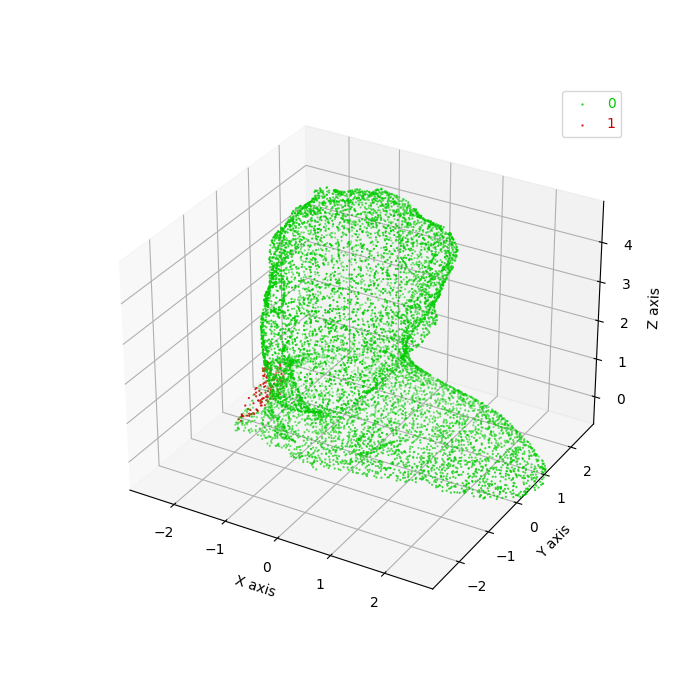

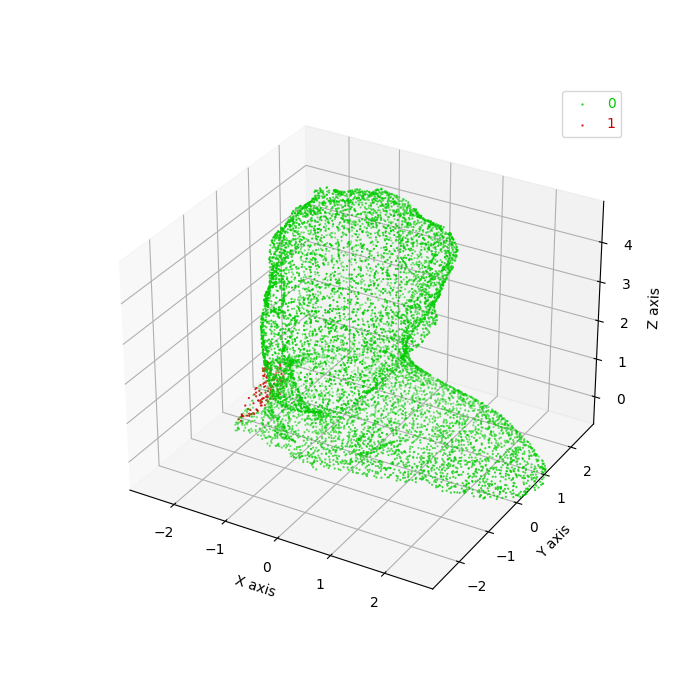

In [ ]:
from jhutil import to_cuda
from jhutil import show_point_clouds
from torch.nn import Softmax

for i, data in enumerate(val_loader):
    import jhutil; jhutil.jhprint(1111, data)
    # data = pipe_transform(data)
    data['x'] = get_features_by_keys(data, cfg.feature_keys)
    import jhutil; jhutil.jhprint(4444, data)
    data = to_cuda(data)
    res = model(data).argmax(dim=1)
    

    pos = data['pos'][0].cpu()
    target = data['y'].squeeze(-1)

    ptd = []
    for j in range(2):
        ptd.append(pos[target.ravel().cpu() == j])

    show_point_clouds(ptd)
    
    pos = data['pos'][0].cpu()

    ptd = []
    for j in range(2):
        ptd.append(pos[res.ravel().cpu() == j])

    show_point_clouds(ptd)
    if i == 3:
        break

# 2. S3DIS Segmentation

## import and config

In [32]:
import argparse
import yaml
import os
import logging
import numpy as npb
import csv
import wandb
import glob
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import distributed as dist, multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter
# from torch_scatter import scatter
from openpoints.utils import set_random_seed, save_checkpoint, load_checkpoint, resume_checkpoint, setup_logger_dist, \
    cal_model_parm_nums, Wandb, generate_exp_directory, resume_exp_directory, EasyConfig, dist_utils, find_free_port
from openpoints.utils import AverageMeter, ConfusionMatrix, get_mious
from openpoints.dataset import build_dataloader_from_cfg, get_features_by_keys, get_class_weights
from openpoints.dataset.data_util import voxelize
from openpoints.dataset.semantic_kitti.semantickitti import load_label_kitti, load_pc_kitti, remap_lut_read, remap_lut_write, get_semantickitti_file_list
from openpoints.transforms import build_transforms_from_cfg
from openpoints.optim import build_optimizer_from_cfg
from openpoints.scheduler import build_scheduler_from_cfg
from openpoints.loss import build_criterion_from_cfg
from openpoints.models import build_model_from_cfg
import warnings

In [33]:
import sys
sys.argv = ["examples/segmentation/main.py" ,"--cfg" ,"cfgs/part_assembly/pointnext-s.yaml"]


In [14]:
def get_config():
    parser = argparse.ArgumentParser('Scene segmentation training/testing')
    parser.add_argument('--cfg', type=str, required=True, help='config file')
    parser.add_argument('--profile', action='store_true', default=False, help='set to True to profile speed')
    args, opts = parser.parse_known_args()
    cfg = EasyConfig()
    cfg.load(args.cfg, recursive=True)
    cfg.update(opts)  # overwrite the default arguments in yml
    
    if cfg.seed is None:
        cfg.seed = np.random.randint(1, 10000)
    
    # init distributed env first, since logger depends on the dist info.
    cfg.rank, cfg.world_size, cfg.distributed, cfg.mp = dist_utils.get_dist_info(cfg)
    cfg.sync_bn = cfg.world_size > 1
    
    # init log dir
    cfg.task_name = args.cfg.split('.')[-2].split('/')[-2]  # task/dataset name, \eg s3dis, modelnet40_cls
    cfg.cfg_basename = args.cfg.split('.')[-2].split('/')[-1]  # cfg_basename, \eg pointnext-xl
    tags = [
        cfg.task_name,  # task name (the folder of name under ./cfgs
        cfg.mode,
        cfg.cfg_basename,  # cfg file name
        f'ngpus{cfg.world_size}',
        f'seed{cfg.seed}',
    ]
    opt_list = []  # for checking experiment configs from logging file
    for i, opt in enumerate(opts):
        if 'rank' not in opt and 'dir' not in opt and 'root' not in opt and 'pretrain' not in opt and 'path' not in opt and 'wandb' not in opt and '/' not in opt:
            opt_list.append(opt)
    cfg.root_dir = os.path.join(cfg.root_dir, cfg.task_name)
    cfg.opts = '-'.join(opt_list)
    
    cfg.is_training = cfg.mode not in ['test', 'testing', 'val', 'eval', 'evaluation']
    if cfg.mode in ['resume', 'val', 'test']:
        resume_exp_directory(cfg, pretrained_path=cfg.pretrained_path)
        cfg.wandb.tags = [cfg.mode]
    else:
        generate_exp_directory(cfg, tags, additional_id=os.environ.get('MASTER_PORT', None))
        cfg.wandb.tags = tags
    os.environ["JOB_LOG_DIR"] = cfg.log_dir
    cfg_path = os.path.join(cfg.run_dir, "cfg.yaml")
    with open(cfg_path, 'w') as f:
        yaml.dump(cfg, f, indent=2)
        os.system('cp %s %s' % (args.cfg, cfg.run_dir))
    cfg.cfg_path = cfg_path
    
    # wandb config
    cfg.wandb.name = cfg.run_name
    
    if cfg.model.get('in_channels', None) is None:
        cfg.model.in_channels = cfg.model.encoder_args.in_channels
        
    return cfg

cfg = get_config()
set_random_seed(cfg.seed + cfg.rank, deterministic=cfg.deterministic)
torch.backends.cudnn.enabled = True

launch mp with 1 GPUs, current rank: 0


In [35]:

import jhutil; jhutil.jhprint(1111, cfg)

1111  {
    "dist_url": "tcp://localhost:8888",
    "dist_backend": "nccl",
    "multiprocessing_distributed": false,
    "ngpus_per_node": 1,
    "world_size": 1,
    "launcher": "mp",
    "local_rank": 0,
    "use_gpu": true,
    "seed": 4979,
    "epoch": 0,
    "epochs": 100,
    "ignore_index": null,
    "val_fn": "validate",
    "deterministic": false,
    "sync_bn": false,
    "criterion_args": {
        "NAME": "CrossEntropy",
        "label_smoothing": 0.2
    },
    "use_mask": false,
    "grad_norm_clip": 10,
    "layer_decay": 0,
    "step_per_update": 1,
    "start_epoch": 1,
    "sched_on_epoch": true,
    "wandb": {
        "use_wandb": false,
        "project": "PointNeXt-S3DIS",
        "tags": [
            "part_assembly",
            "train",
            "pointnext-s",
            "ngpus1",
            "seed4979"
        ],
        "name": "part_assembly-train-pointnext-s-ngpus1-seed4979-20230627-204251-Sx93w7ZytwMRkkzWMLgdC8"
    },
    "use_amp": false,
    "use_v

## model & data_loader

In [36]:
model = build_model_from_cfg(cfg.model).to(cfg.rank)
model_size = cal_model_parm_nums(model)

[2023-06-27 20:42:52] [INFO] radius: [[0.1], [0.1], [0.2], [0.4], [0.8]],
 nsample: [[32], [32], [32], [32], [32]]
[2023-06-27 20:42:52] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.1
nsample: 32
[2023-06-27 20:42:52] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.2
nsample: 32
[2023-06-27 20:42:52] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.4
nsample: 32
[2023-06-27 20:42:52] [INFO] NAME: ballquery
normalize_dp: True
radius: 0.8
nsample: 32


In [37]:
val_loader = build_dataloader_from_cfg(cfg.get('val_batch_size', cfg.batch_size),
                                       cfg.dataset,
                                       cfg.dataloader,
                                       datatransforms_cfg=cfg.datatransforms,
                                       split='val',
                                       distributed=cfg.distributed
                                    )

[2023-06-27 20:42:55] [INFO] 
Totally 17686 samples in val set


In [38]:
for idx, data in enumerate(val_loader):
    break

import jhutil; jhutil.jhprint(1111, data)

1111  {
    "pos": "tensor[1, 29751, 3] n=89253 (0.3Mb) x∈[-1.916, 5.608] μ=0.942 σ=1.797",
    "x": "tensor[1, 29751, 3] n=89253 (0.3Mb) x∈[-8.267, 2.856] μ=-2.609 σ=3.111",
    "y": "tensor[1, 29751] i64 0.2Mb x∈[0, 1] μ=0.137 σ=0.344",
    "heights": "tensor[1, 29751, 1] 0.1Mb x∈[0., 5.608] μ=2.827 σ=1.612"
}


## RUN !!!

In [39]:
val_loader.dataset[5041]

{'pos': tensor[56, 3] n=168 x∈[-0.076, 0.396] μ=0.084 σ=0.137,
 'x': tensor[56, 3] n=168 x∈[-7.436, 2.107] μ=-2.399 σ=3.129,
 'y': tensor[56] i64 x∈[1, 1] μ=1.000 σ=0.,
 'heights': tensor[56, 1] x∈[0.030, 0.427] μ=0.282 σ=0.107}

In [40]:
cfg.num_classes, cfg.ignore_index

(2, None)

In [48]:
model.eval()  # set model to eval mode
cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)

import jhutil; jhutil.jhprint(1111, cm.virtual_num_classes, cm.value)
pbar = tqdm(enumerate(val_loader), total=val_loader.__len__(), desc='Val')
for idx, data in pbar:
    keys = data.keys() if callable(data.keys) else data.keys
    for key in keys:
        data[key] = data[key].cuda(non_blocking=True)
    target = data['y'].squeeze(-1)
    if target.size(1) < 256:
        import jhutil; jhutil.jhprint(1111, len(target))
        continue
    x = data['x']
    data['x'] = get_features_by_keys(data, cfg.feature_keys)
    

    logits = model(data)
    break
    
    

1111  "2" "0"


Val:   0%|          | 0/17686 [00:04<?, ?it/s]


In [49]:
data

{'pos': tensor[1, 29751, 3] n=89253 (0.3Mb) x∈[-1.916, 5.612] μ=0.942 σ=1.797 cuda:0,
 'x': tensor[1, 4, 29751] n=119004 (0.5Mb) x∈[-8.267, 5.612] μ=-1.248 σ=3.667 cuda:0,
 'y': tensor[1, 29751] i64 0.2Mb x∈[0, 1] μ=0.137 σ=0.344 cuda:0,
 'heights': tensor[1, 29751, 1] 0.1Mb x∈[0., 5.612] μ=2.827 σ=1.612 cuda:0}

In [ ]:

cm = ConfusionMatrix(num_classes=cfg.num_classes, ignore_index=cfg.ignore_index)
pbar = tqdm(enumerate(val_loader), total=val_loader.__len__(), desc='Val')
for idx, data in pbar:
    keys = data.keys() if callable(data.keys) else data.keys
    for key in keys:
        data[key] = data[key].cuda(non_blocking=True)
    target = data['y'].squeeze(-1)
    # if len(target) < 256:
    #     continue
    data['x'] = get_features_by_keys(data, cfg.feature_keys)
    logits = model(data)
    if 'mask' not in cfg.criterion_args.NAME or cfg.get('use_maks', False):
        cm.update(logits.argmax(dim=1), target)
    else:
        mask = data['mask'].bool()
        cm.update(logits.argmax(dim=1)[mask], target[mask])
    break


Val:   0%|          | 0/17686 [00:00<?, ?it/s]


In [ ]:
cm.tp
cm.union
cm.count

tensor[2] i64 μ=1.488e+04 σ=1.527e+04 cuda:0 [25672, 4079]

In [51]:
import jhutil; jhutil.jhprint(1111, data)

1111  {
    "pos": "tensor[1, 29751, 3] n=89253 (0.3Mb) x∈[-1.916, 5.612] μ=0.942 σ=1.797 cuda:0",
    "x": "tensor[1, 4, 29751] n=119004 (0.5Mb) x∈[-8.267, 5.612] μ=-1.248 σ=3.667 cuda:0",
    "y": "tensor[1, 29751] i64 0.2Mb x∈[0, 1] μ=0.137 σ=0.344 cuda:0",
    "heights": "tensor[1, 29751, 1] 0.1Mb x∈[0., 5.612] μ=2.827 σ=1.612 cuda:0"
}


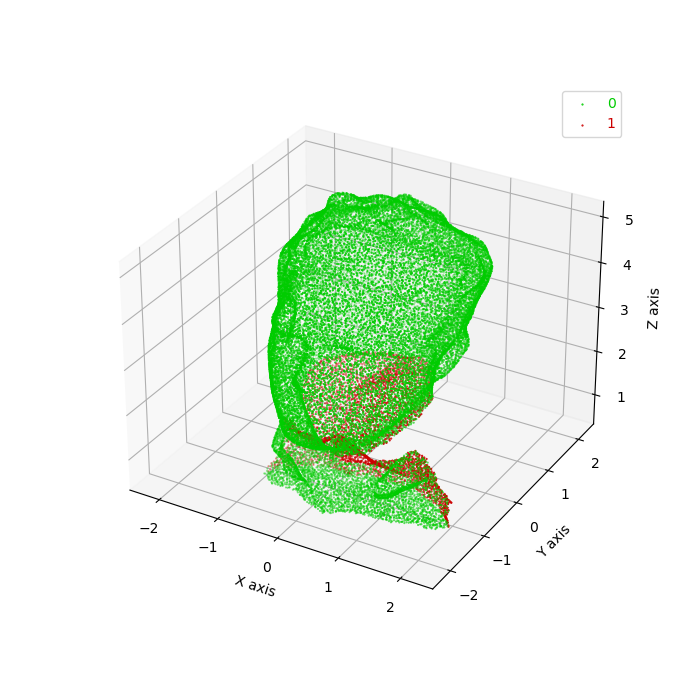

In [53]:
# x = data['x'][0].transpose(0, 1)[:, :3].cpu()
target = data["y"]
show_point_clouds([data["pos"][target==0].cpu(), data["pos"][target==1].cpu()])